In [301]:
using MarketData
using DataFrames
using Distributions
using StatsBase
using RollingFunctions
using Pipe
using Plots
using Dates
using PyCall
talib = pyimport("talib")

ta = MarketData.yahoo("^N225")
df = DataFrame(ta)

# df = df[df.timestamp .> Date(201, 8, 1), :]
first(df, 5)

size(df)

(13578, 7)


$$
w_i = \frac{\alpha_k}{\sum{\alpha_k}} = \frac{\exp(\beta_k)}{\sum_k \exp(\beta_k)}
= \frac{\exp(\beta_k - c)}{\sum_k \exp(\beta_k - c)}

$$

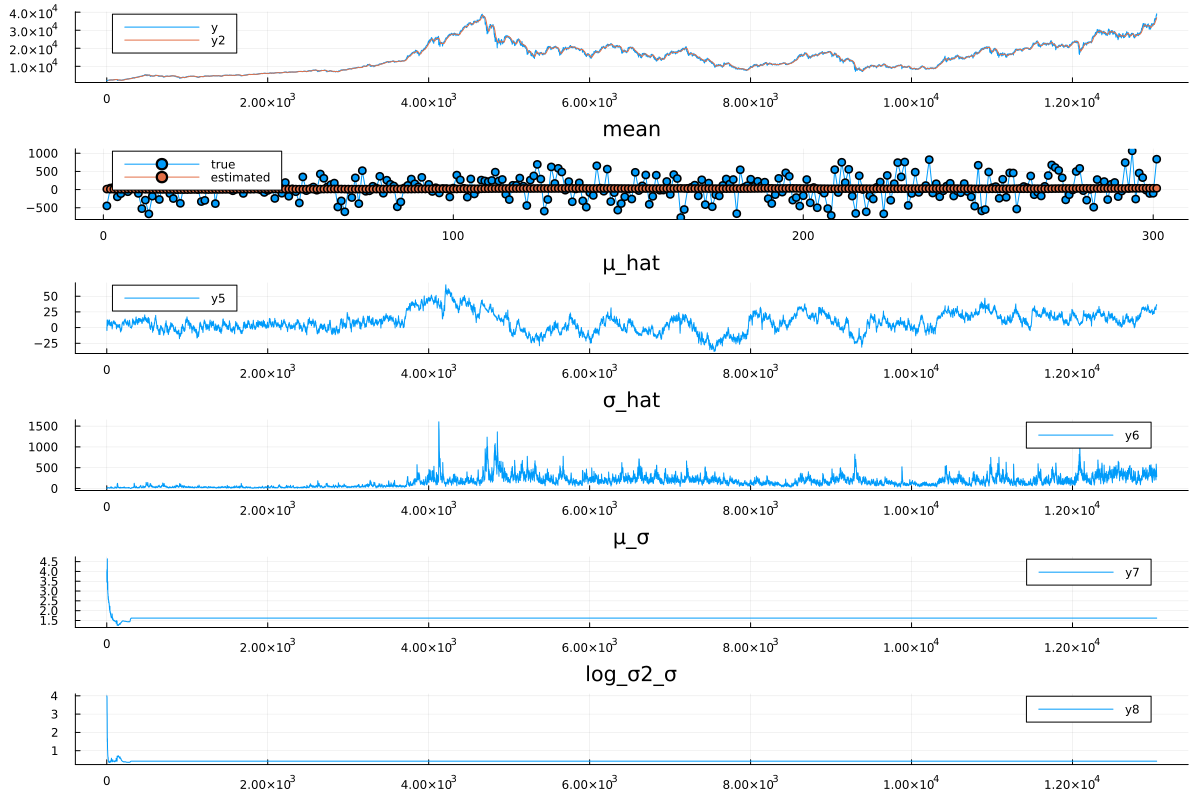

In [302]:

function particle_filter(y; n_particles=10000)

    n_particle_dim = 5
    particles = zeros(n_particle_dim, n_particles)
    particles[1,:] = randn(n_particles) * 10 # ローカルレベルの平均 μ
    particles[2,:] = rand(n_particles) * 1000 .- 500 # 観測雑音の分散 log_σ2
    particles[3, :] = rand(truncated(Normal(0, 5), lower=0.0), n_particles) # log_σ2 for μ
    particles[4, :] = rand(truncated(Normal(0, 5), lower=0.0), n_particles) # log_σ2 for log_σ2
    particles[5, :] = rand(n_particles) * 100 # ν

    predicted = zeros(n_particle_dim, n_particles)
    weights = zeros(n_particles)
    sys_noise_dists = [
        Normal(0, 1), # μ
        Normal(0, 1), # σ
    ]
    
    transit = (x) -> x + rand(d)
    observe= (x) -> x
    
    results = Dict{Symbol, DataFrame}(
        :y => DataFrame(), 
        :μ => DataFrame(),
        :log_σ2 => DataFrame(),
        :μ_σ => DataFrame(),
        :log_σ2_σ => DataFrame(),
        :ν => DataFrame(),
    )
    
    for i in axes(y,1)
        # next state
        for j in axes(particles, 1)
            j > 2 && continue
            for k in axes(particles, 2)
                # σ = sqrt(exp(particles[2+j, k])) + 1e-9
                σ = particles[2+j, k] + 1e-9
                dist = Normal(0, σ)
                particles[j,k] += rand(dist)
            end
        end
        push!(results[:μ], (
            mean=mean(particles[1, :]),
            q25=quantile(particles[1, :], 0.25),
            q75=quantile(particles[1, :], 0.75),
        ))
        push!(results[:log_σ2], (
            mean=mean(particles[2, :]),
            q25=quantile(particles[2, :], 0.25),
            q75=quantile(particles[2, :], 0.75),
        ))
        push!(results[:μ_σ], (
            mean=mean(particles[3, :]),
            q25=quantile(particles[3, :], 0.25),
            q75=quantile(particles[3, :], 0.75),
        ))
        push!(results[:log_σ2_σ], (
            mean=mean(particles[4, :]),
            q25=quantile(particles[4, :], 0.25),
            q75=quantile(particles[4, :], 0.75),
        ))
        push!(results[:ν], (
            mean=mean(particles[5, :]),
            q25=quantile(particles[5, :], 0.25),
            q75=quantile(particles[5, :], 0.75),
        ))

        # observation
        for j in axes(particles, 2)
            predicted[:,j] = observe(particles[:,j])
        end

        for k in eachindex(weights)
            σ = sqrt(exp(predicted[2, k])) + 1e-9
            # ν = sqrt(exp(predicted[5, k])) + 1e-9
            ν = predicted[5, k] + 1e-9
            # obs_noise_dist = LocationScale(predicted[1, k], σ, TDist(ν))
            obs_noise_dist = Normal(predicted[1,k], σ)
            weights[k] = loglikelihood(obs_noise_dist, y[i])
        end
        
        weights .= exp.(weights .- maximum(weights))
        weights ./= sum(weights)
        particles = particles[:, rand(Categorical(weights), n_particles)]

        push!(results[:y], (
            mean=mean(predicted[1,:]), 
            q25=quantile(predicted[1,:], 0.25), 
            q75=quantile(predicted[1,:], 0.75),
        ))

        # (i-1) % 10 == 0 && @info "iter=$i"
    end
    results
end

# 価格差をモデリングする
# TODO: 定常状態になるまでwamup期間を考慮する
df = dropmissing(df)
ts = df[:, :timestamp]
y = df[:, :AdjClose]
y_diff = diff(y)
results = particle_filter(y_diff)
yhat = results[:y]
μ_hat = results[:μ]
log_σ2_hat = results[:log_σ2]

μ_σ = results[:μ_σ]
log_σ2_σ = results[:log_σ2_σ]

ν = results[:ν]

let y = y, y_diff = y_diff[end-300:end, :], yp = yhat[end-300:end, :]
    p = plot(layout=(6, 1), size=(1200, 800))
    plot!(p[1], y, label="y")
    plot!(p[1], rolling(mean, y, 25, padding=missing))
    plot!(p[2], y_diff, label="true", title="mean", marker=(:circle, 4))
    plot!(p[2], yp.mean, ribbon=(yp.q75 .- yp.q25), label="estimated", marker=(:circle, 4))
    plot!(p[3], μ_hat.mean, title="μ_hat")
    plot!(p[4], sqrt.(exp.(log_σ2_hat.mean)), title="σ_hat")
    plot!(p[5], μ_σ.mean, title="μ_σ")
    plot!(p[6], log_σ2_σ.mean[:], title="log_σ2_σ")
end

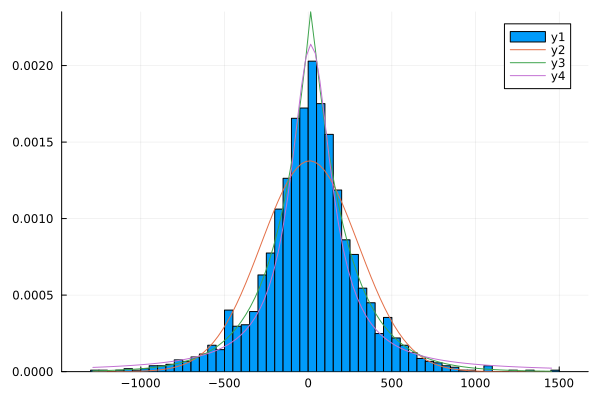

In [239]:
using StatsPlots
p = histogram(y_diff, normalize=:pdf, bins=100)
normal = fit(Normal, y_diff)
laplace = fit(Laplace, y_diff)
cauchy = fit(Cauchy, y_diff)
xrange = range(minimum(y_diff), maximum(y_diff), length=100)
plot!(xrange, pdf.(normal, xrange))
plot!(xrange, pdf.(laplace, xrange))
plot!(xrange, pdf.(cauchy, xrange))